## Toronto Islands Ferry Tickets Forcasting 

In [1]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime

import plotly.io as pio
pio.renderers.default = "browser"

In [2]:
cur_dir = Path().cwd()
data_path = cur_dir.parent / "data" / "raw" / "Toronto Island Ferry Ticket Counts.csv"

In [3]:
## Read data
data = pd.read_csv(data_path)

In [4]:
display(data.head())

display(data.info())


,_id,Timestamp,Redemption Count,Sales Count
0,1,2025-07-01T14:45:00,557,488
1,2,2025-07-01T14:30:00,533,481
2,3,2025-07-01T14:15:00,535,448
3,4,2025-07-01T14:00:00,470,515
4,5,2025-07-01T13:45:00,407,465


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248501 entries, 0 to 248500
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   _id               248501 non-null  int64 
 1   Timestamp         248501 non-null  object
 2   Redemption Count  248501 non-null  int64 
 3   Sales Count       248501 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.6+ MB


None

In [5]:
data.drop(columns=['_id'], axis=1, inplace=True)

In [6]:
data['Timestamp'] = pd.to_datetime(data["Timestamp"])

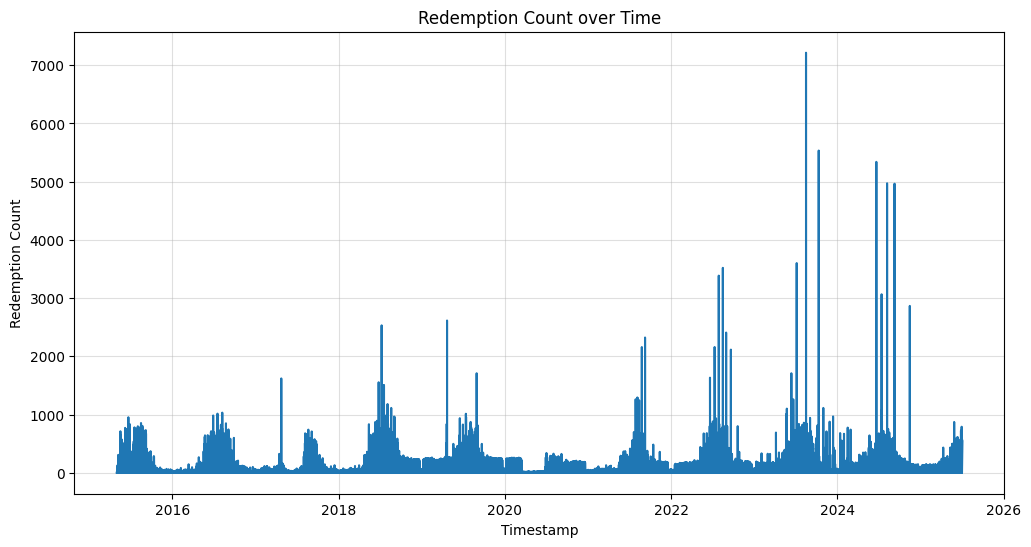

In [7]:
plt.figure(figsize=(12,6))
sns.lineplot(data, x='Timestamp', y='Redemption Count')
plt.title("Redemption Count over Time")
plt.grid(alpha=0.4)
plt.show()

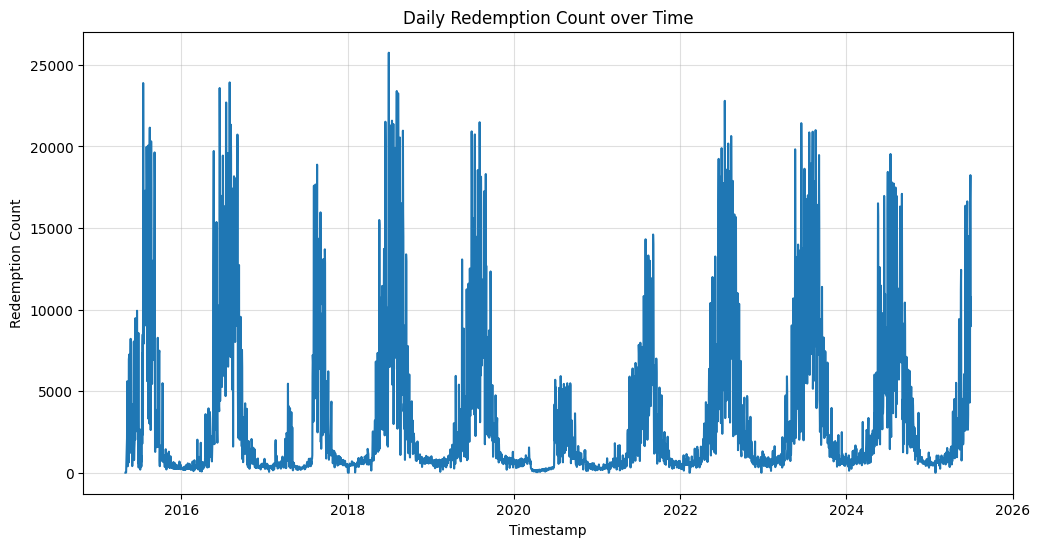

In [8]:
data_daily = data.resample(rule='D', on='Timestamp').sum().reset_index()
plt.figure(figsize=(12,6))
sns.lineplot(data_daily, x='Timestamp', y='Redemption Count')
plt.title("Daily Redemption Count over Time")
plt.grid(alpha=0.4)
plt.show()

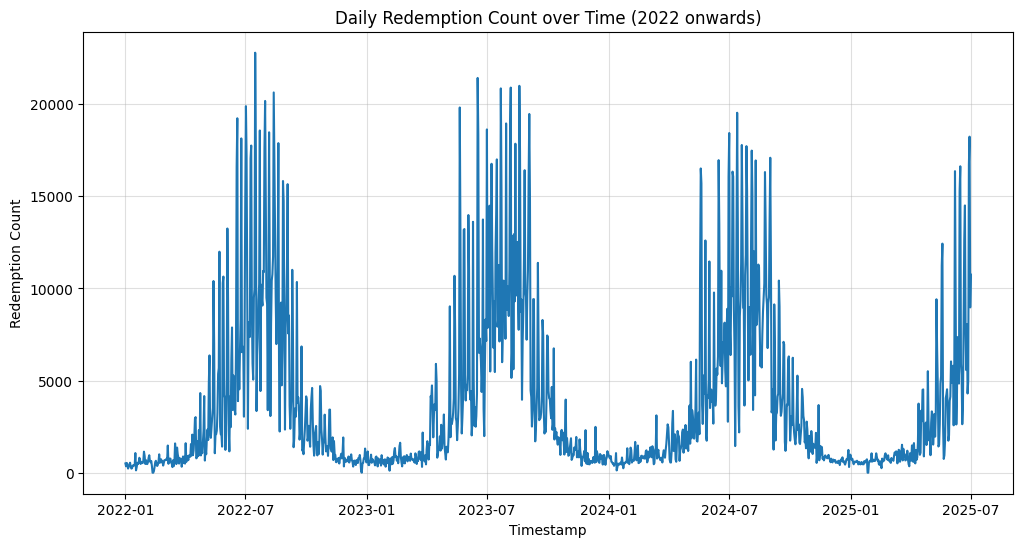

In [9]:
data_2022 = data_daily[data_daily["Timestamp"]>='2022-01-01']
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(data_2022, x='Timestamp', y='Redemption Count', ax=ax)
ax.set_title("Daily Redemption Count over Time (2022 onwards)")
ax.grid(alpha=0.4)
plt.show()

### What the plot speaks out:

* There is yearly seasonality (summer high, winter low)

* This pattern is consistent across multiple years, reinforcing the presence of annual seasonality.
  
* There are spikes - on certain occasions the ticket sales goes high


In [10]:
display(data_2022.describe())

,Timestamp,Redemption Count,Sales Count
count,1278,1278.000000,1278.000000
mean,2023-10-01 12:00:00,3703.767606,3673.842723
min,2022-01-01 00:00:00,0.000000,0.000000
25%,2022-11-16 06:00:00,749.500000,649.250000
50%,2023-10-01 12:00:00,1653.000000,1610.000000
75%,2024-08-15 18:00:00,4741.000000,5070.250000
max,2025-07-01 00:00:00,22798.000000,20498.000000
std,NaN,4455.758230,4366.795835


### Basic Statistics 

* The mean ticket count is approximately 3,700, while the median (50th percentile) is around 1,600, indicating a right-skewed distribution. This suggests that a few extreme high values are pulling the mean above the median.

* A high standard deviation of 4,440 tickets reflects a wide dispersion in daily ticket sales, pointing to substantial variability across days. 

In [11]:
import numpy as np

In [12]:
data_log_transformed = data_2022.copy()
data_log_transformed['Redemption Count'] = data_log_transformed['Redemption Count'].apply(lambda x: np.log1p(x))
data_log_transformed['Sales Count'] = data_log_transformed['Sales Count'].apply(lambda x: np.log1p(x))


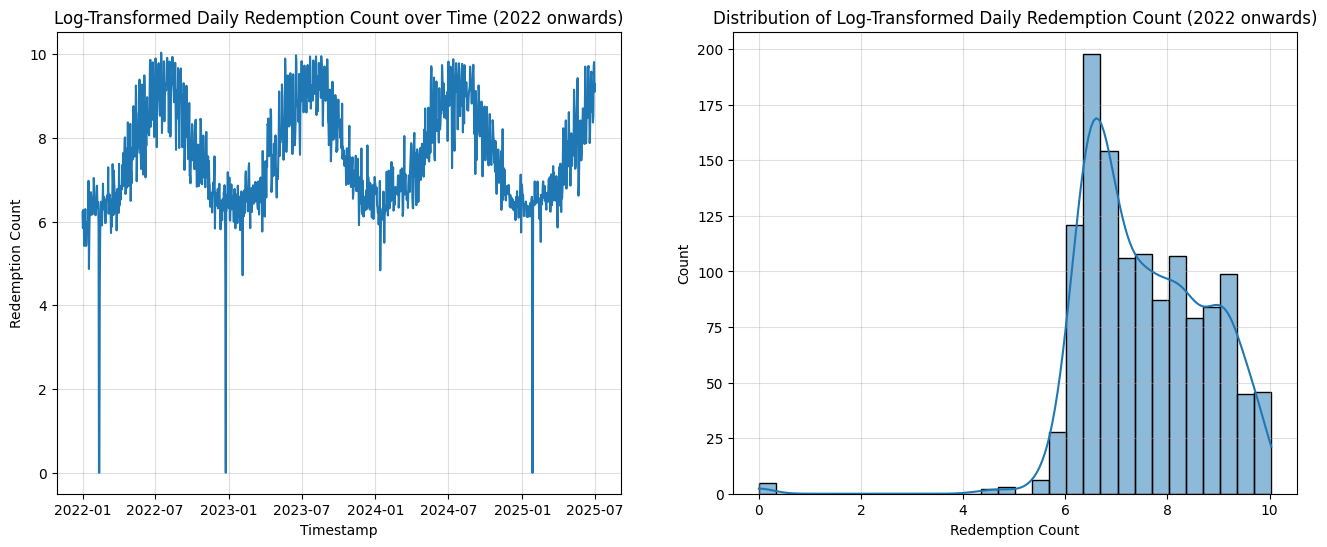

In [13]:
fig, ax = plt.subplots(1,2, figsize=(16,6))
sns.lineplot(data_log_transformed, x='Timestamp', y='Redemption Count', ax=ax[0])
ax[0].set_title("Log-Transformed Daily Redemption Count over Time (2022 onwards)")
ax[0].grid(alpha=0.4)
sns.histplot(data_log_transformed, x='Redemption Count', kde=True, ax=ax[1])
ax[1].set_title("Distribution of Log-Transformed Daily Redemption Count (2022 onwards)")
ax[1].grid(alpha=0.4)   
plt.show()

### Log transforamtion

* log transformation stabilizes the variance, reduces the impact of large spikes

* normalize the distribution, I mean, making the data close to normal distribution

In [14]:
data_diff = data_log_transformed.copy()
data_diff['diff_redemption_count'] = data_diff['Redemption Count'].diff().dropna()

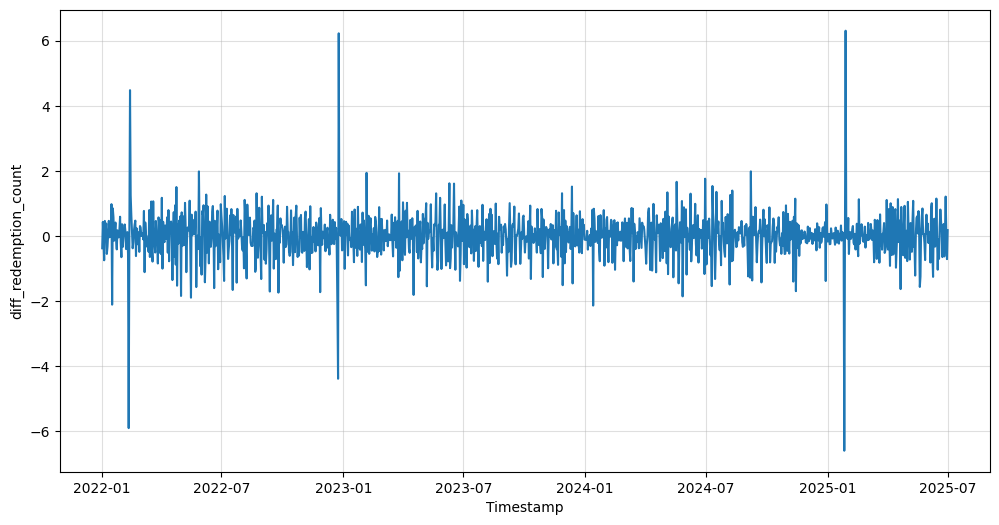

In [15]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(data_diff, x='Timestamp', y='diff_redemption_count', ax=ax)
plt.grid(alpha=0.4)
plt.show()

### one-step differencing of log-transformed time-series

* Log transformation stabilizes the variance and reduce the impact of spikes

* one-step differencing now removes the trend, making the time-series stationary. 

* one-step differencing represents the relative changes or growth rate in redemption counts from one day to the next.

* it centers around zero with occasional spkies and dips

In [16]:
data_diff.head()

,Timestamp,Redemption Count,Sales Count,diff_redemption_count
2437,2022-01-01,6.222576,6.156979,NaN
2438,2022-01-02,5.846439,5.777652,-0.376137
2439,2022-01-03,6.278521,6.222576,0.432083
2440,2022-01-04,6.165418,6.023448,-0.113104
2441,2022-01-05,5.420535,5.308268,-0.744883


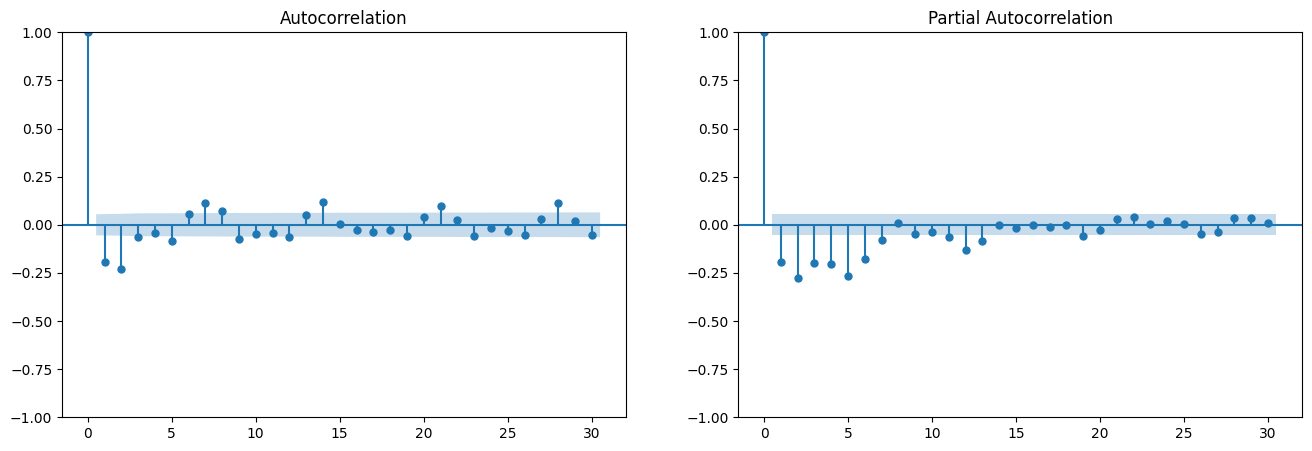

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig1, axes = plt.subplots(1,2, figsize=(16,5))
plot_acf(data_diff['diff_redemption_count'].dropna(), lags=30, ax=axes[0])
plot_pacf(data_diff['diff_redemption_count'].dropna(), lags=30, ax=axes[1])
plt.show()


### Auto-correlation and Partial Auto-correlation of 1-step differencing of log-transformed time series

* PACF suggests significant auto-correlation at lag 1, 2, 3, 4, 5 and 6. After that the correlation dies. We can try with AR(p) p from 1 to 6 and see the BIC

* ACF suggests signification relationships at lag 1 and 2. q could be 1 or 12

In [18]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

# Run the test
result = adfuller(data_diff['diff_redemption_count'].dropna())

# Organize results
adf_output = {
    'ADF Statistic': result[0],
    'p-value': result[1],
    'Number of Lags Used': result[2],
    'Number of Observations Used': result[3],
    'Critical Values': result[4],
    'IC Best (AIC)': result[5]
}

# Display as DataFrame
adf_df = pd.DataFrame.from_dict(adf_output, orient='index', columns=['Value'])
print(adf_df)


                                                                         Value
ADF Statistic                                                       -16.285116
p-value                                                                    0.0
Number of Lags Used                                                         12
Number of Observations Used                                               1264
Critical Values              {'1%': -3.4355340425478706, '5%': -2.863829299...
IC Best (AIC)                                                      2274.831503


### Augmented Dickey-Fuller test

* p-value = 0 suggestes that the data does not provide enough evidence in favor of the null hypothesis that the time series has a unit root - the series is non-staionary.

* So we reject the Null Hypothesis that the series is non-stationary. 

* 1-step differencing of log-transformation has made the seties stationary.

In [21]:
data_2022.to_parquet(cur_dir.parent / "data" / "processed" / "daily_tickets_2022_25.parquet")

In [19]:
# from prophet import Prophet
# from sklearn.model_selection import TimeSeriesSplit
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# import matplotlib.pyplot as plt
# import plotly.graph_objects as go
# import numpy as np

In [20]:
# # --- Prepare data ---
# df= data_2022.rename(columns={'Timestamp':'ds', 'Redemption Count':'y'})
# # df must have columns ['ds', 'y']
# df['ds'] = pd.to_datetime(df['ds'])
# df = df.sort_values('ds')

# # --- Setup rolling splits (30-day horizon) ---
# tscv = TimeSeriesSplit(n_splits=3, test_size=30)

# mae_scores, rmse_scores, coverage_scores = [], [], []

# for fold, (train_idx, test_idx) in enumerate(tscv.split(df), 1):
#     train = df.iloc[train_idx]
#     test  = df.iloc[test_idx]

#     # --- Fit Prophet ---
#     model = Prophet(
#         yearly_seasonality=True,
#         weekly_seasonality=True,
#         interval_width=0.95  # 95% confidence band
#     )
#     model.fit(train)

#     # --- Forecast only on test dates ---
#     future = test[['ds']].copy()
#     forecast = model.predict(future)

#     # --- Evaluate ---
#     y_true = test['y'].values
#     y_pred = forecast['yhat'].values
#     y_lower = forecast['yhat_lower'].values
#     y_upper = forecast['yhat_upper'].values

#     mae  = mean_absolute_error(y_true, y_pred)
#     rmse = np.sqrt(mean_squared_error(y_true, y_pred))

#     # Coverage: % of actual values within prediction interval
#     coverage = np.mean((y_true >= y_lower) & (y_true <= y_upper))

#     mae_scores.append(mae)
#     rmse_scores.append(rmse)
#     coverage_scores.append(coverage)

#     print(f"Fold {fold}: MAE={mae:.2f}, RMSE={rmse:.2f}, Coverage={coverage:.2%}")

#     # # --- Plot forecast ---
#     # plt.figure(figsize=(10,5))
#     # plt.plot(train['ds'][-300:], train['y'][-300:], label='Train', color='steelblue')
#     # plt.plot(test['ds'], test['y'], label='Actual (Test)', color='black')
#     # plt.plot(forecast['ds'], forecast['yhat'], label='Forecast (Median)', color='orange')
#     # plt.fill_between(
#     #     forecast['ds'], y_lower, y_upper,
#     #     color='orange', alpha=0.2, label='95% Interval'
#     # )
#     # plt.title(f'Prophet Fold {fold} Forecast (Next 30 Days)')
#     # plt.xlabel('Date')
#     # plt.ylabel('y')
#     # plt.legend()
#     # plt.tight_layout()
#     # plt.show()
    
    
 

#     # --- Plot forecast (Plotly version) ---
#     fig = go.Figure()

#     # show only last 300 days of training for readability
#     fig.add_trace(go.Scatter(
#         x=train['ds'][-180:], y=train['y'][-180:],
#         mode='lines', name='Train', line=dict(color='steelblue')
#     ))

#     fig.add_trace(go.Scatter(
#         x=test['ds'], y=test['y'],
#         mode='markers', name='Actual (Test)', marker=dict(color='black', size=6, symbol='circle')
#     ))

#     fig.add_trace(go.Scatter(
#         x=forecast['ds'], y=forecast['yhat'],
#         mode='lines', name='Forecast (Median)', line=dict(color='orange')
#     ))

#     # 95% confidence interval (as filled band)
#     fig.add_trace(go.Scatter(
#         x=pd.concat([forecast['ds'], forecast['ds'][::-1]]),
#         y=pd.concat([forecast['yhat_upper'], forecast['yhat_lower'][::-1]]),
#         fill='toself',
#         fillcolor='rgba(255,165,0,0.2)',
#         line=dict(color='rgba(255,255,255,0)'),
#         hoverinfo="skip",
#         name='95% Interval'
#     ))

#     fig.update_layout(
#         title=f'Prophet Fold {fold} Forecast (Next 30 Days)',
#         xaxis_title='Date',
#         yaxis_title='y',
#         template='plotly_white',
#         legend=dict(x=0.02, y=0.98),
#         height=500,
#         width=900
#     )
#     # Save plot to HTML file
#     timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
#     fig_path = cur_dir.parent / "output" / "plots" / f"fold_{fold}_forecast_{timestamp}.html"

#     fig.write_html(str(fig_path), include_plotlyjs='cdn')

#     fig.show()


# # --- Average metrics ---
# print("\n===== Average Metrics Across Folds =====")
# print(f"MAE:      {np.mean(mae_scores):.2f}")
# print(f"RMSE:     {np.mean(rmse_scores):.2f}")
# print(f"Coverage: {np.mean(coverage_scores):.2%}")
